In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from biotorch.benchmark.run import Benchmark
from biotorch.module.biomodule import BioModule

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Feedback Alignment on MNIST

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, 
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, 
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

print("Train size: ", len(train_loader.dataset))
print("Test size: ", len(test_loader.dataset))

Train size:  60000
Test size:  10000


In [4]:
# create an ANN model using pytorch of 3 layers with
# 1. 784 input neurons
# 2. 50 hidden neurons
# 3. 10 output neurons

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
# covert the ANN model to a BioModule model

model = ANN()
fa = BioModule(model, mode='dfa', output_dim=10)
print(fa)

Module has been converted to dfa mode:

The layer configuration was:  {'type': 'dfa', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 2 <class 'torch.nn.modules.linear.Linear'> layers were converted successfully.
BioModule(
  (module): ANN(
    (fc1): Linear(in_features=784, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [13]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [16]:
network = fa

In [17]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [18]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3315, Accuracy: 1449/10000 (14%)



C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


ValueError: Targets missing for Direct Feedback Alignment mode

In [ ]:
network = model

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2771, Accuracy: 1504/10000 (15%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.230740
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.217782
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.071470
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.778829
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.228550
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.895057
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.653168
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.687505
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.862351
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.589438
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.746260
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.786535
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.518141
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.501664
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.609061
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.321234
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.471496
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.512135
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.604539
Train Epoch: 1 [12160

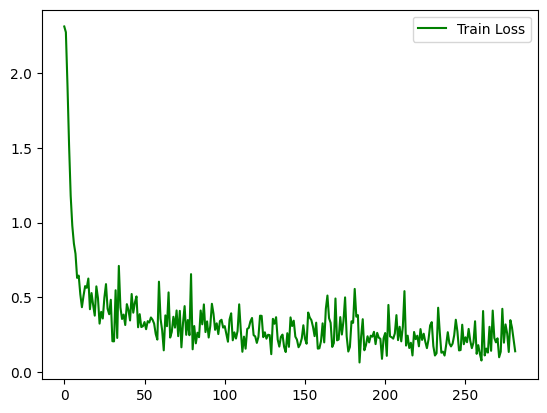

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plt.plot(train_losses, np.arange())
#plot the training loss vs epoch graph

plt.plot(train_losses, color='g')
plt.legend(['Train Loss'], loc='upper right')

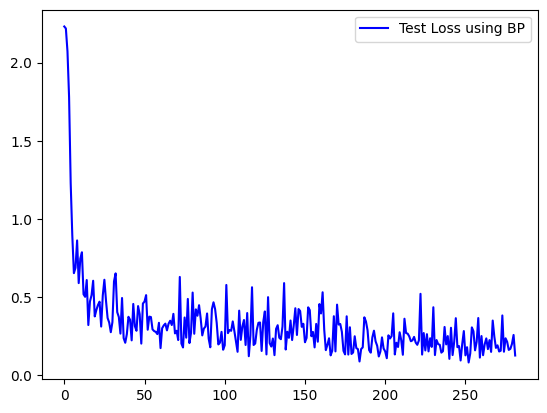

In [ ]:
plt.plot(train_losses[int(len(train_losses)/2):], color='b')
plt.legend(['Test Loss using BP'], loc='upper right')